# Part 4: Train a Model
In the previous notebooks, we covered downloading and working with images, getting ground-truth data from OSM, and converting OSM data into image masks.  Now we can move onto actually training an NN on this data.

But first, we need to assemble a trainnig set, and to do that we're going to have to combine everything we've done up until now.

I'm going to use 3 target categories: residential areas, woods, and water.  The data is pretty sparse, so I want to make sure there are a lot of targets to hit.  That's my main reason for using three targets instead of just one.  Also I'm showing off how easy it is to do that.

In [1]:
import os

import cv2
import geopandas as gpd
import h5py # just a safety check so the checkpoint callback doesnt crash
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from scipy.misc import imresize
import shapely.geometry

%matplotlib inline

## Create a dataset
Before we can train an NN, we'll need to build a training set.  So I'll iterate through every image of Paris and then create an image mask to train against.

Paris is the smallest dataset in SpaceNet.  I originally thought that would make it a good starting point.  Unfortunately, Paris just doesn't have enough images to train a model well, so I'd suggest starting with another city (which is not what I did #rolemodel).

First, I'm going to load some of the vectors I downloaded in notebook 2.

In [2]:
# Load the image summary
image_summary = gpd.read_file('vectors/image_summary.geojson')

# Load the nature data from OSM
osm_landuse = gpd.read_file('vectors/landuse.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just residential
residential = osm_landuse[osm_landuse.landuse == 'residential'].unary_union
forest = osm_landuse[osm_landuse.landuse == 'forest'].unary_union

# Now do the same for water
osm_nature = gpd.read_file('vectors/nature.geojson')
osm_nature.set_geometry(osm_nature.geometry.apply(shapely.geometry.Polygon), inplace=True)
water = osm_nature[osm_nature.natural == 'water'].unary_union

vectors = [residential, forest, water]

Now I'll pick out 1000 images and make the corresponding masks.  

At this point, we're going to have to start downsizing the images.  If we let the neural net get too big, it's going to take longer to train.  So I'm going to downsample everything to 240x240 make things work better.

In [3]:
INPUT_SIZE = 240 

# Recycle a couple of functions from previous notebooks...
def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

# Build a training set
def make_set(image_summary, vectors, training_set_size, input_size, random=np.random):
    rows_to_use = random.choice(image_summary.index, training_set_size, replace=False)
    X = []
    Y = []
    for i, row in image_summary.loc[rows_to_use].iterrows():
        with rasterio.open(row.image_name) as src:
                img = src.read().transpose([1,2,0])
                img = resize(img, (input_size, input_size))
                # img = scale_bands(img, lower_pct = 5, upper_pct = 95)
                img_bounds = shapely.geometry.box(*src.bounds)
                img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])

        masks = []
        for poly in vectors:
            # Get the intersection between the polygon and the image bounds
            mask_poly = poly.intersection(img_bounds)

            # Transform it into pixel coordinates
            mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

            # Convert the polygon into a mask
            mask = make_mask(img.shape[:2], mask_poly_pxcoords)
            mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))
            
            masks.append(mask[..., None])
        masks = np.concatenate(masks, axis=2)
        
        # Add each mask to a list
        X.append(img[None, ...]) # These need to be truncated for U-Net
        Y.append(masks[None, ...])

            
    # Concatenate the results
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    # Normalize the values
    X = X.astype('float32')
    X = (X / X.max() - 0.5) * 2 # put X in range [-1, 1]
    Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
    return X, Y

def make_pascal_set(data_list_path, data_path, training_set_size, input_size, random=np.random):
    pass

random = np.random.RandomState(2) 
X_train, Y_train = make_set(image_summary, vectors, 1000, INPUT_SIZE, random)
X_val, Y_val = make_set(image_summary, vectors, 100, INPUT_SIZE, random)

## Build a U-Net model
In order to train a Keras model, you have to build it layer by layer.  The `get_unet` function builds a new U-Net model for you with randomly initialized weights.  A word of warning: Keras is a package going through rapid development.  I had an example I used 2 months ago, and it wouldn't run anymore because the Keras package changed since then.  I order to get it working again, I found a repo with an [up-to-date U-Net model in Keras](https://github.com/jocicmarko/ultrasound-nerve-segmentation/) and copied it.  If you want to see a more detailed training procedure, I'd suggest having a look at that repo.  I'm keeping everything simple here so you can learn the basics before you get consumed by all the details of optimizing training routines.  I also borrowed some ideas from a [Kaggle notebook](https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras).

U-Net is a segmentation model that is known for performing well when you train it from scratch on new data.  It is not as powerful as ResNet or FCN, but it has the advantage that you don't need to do transfer learning to get good results.  So I thought it would be a good starting point.  I have no doubt you can get better results by using a more powerful net with transfer learning.

In [4]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam

# Set network size params
N_CLASSES = 3
N_CHANNEL = 8

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Just put a negative sign in front of an accuracy metric to turn it into a loss to be minimized
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(lr=0.001):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model


Using TensorFlow backend.


Now that the model is built, we can start training it.  I used a bunch of keras callbacks to show some of the cool things you can do with Keras.  

1. **ModelCheckpoint**: This callback saves a checkpoint of the weights on each iteration.  This will let you look back and retrieve a model from different times during training.  I set the checkpoint files to be named according to epoch number and validation loss.  The final cell in this notebook shows how to load a model.
2. **ReduceLROnPlateau**: This callback is designed to lower the learning rate during training.  It monitors the validation loss, and when it sees that the model isn't improving anymore, it automatically decreases the learning rate.  The `patience`, `epsilon`, and `cooldown` parameters determine when the learning rate will reduce and the `factor` parameter determines by how much.
3. **LearningRateScheduler**: Is a simpler way to reduce the learning rate.  It uses a pre-determined function to reduce the learning rate during learning.  You can define whatever function (of epoch number) you want.
4. **TensorBoard**: This callback will save logs for use with TensorBoard.  TensorBoard is a tool for visualizing your NN training.  It runs a web server (sort of like Jupyter) so you can see the visualizations in your browser.  It's built into TensorFlow (which we're using as a backend behind Keras).   Run `tensorboard --logdir=/tmp/tboard_logs --port 6006` to launch the server, and then open localhost:6006 in your browser to see the visualizations.

Then the model.fit function actually trains the NN.  We tell it which callbacks to use by setting the `callbacks` parameter.

I set up this notebook to run 100 epochs.  It's going to just train on the same 1000 images over and over again.  This is NOT a smart way to do training.  You want to keep your NN guessing by varying the training set as much as possible.  You have all the pieces here that you could use to write a smarter training routine.

The `ReduceLROnPlateau` callback should reduce the learning rate whenever you hit diminishing returns.  At some point, even this will stop making things better because the model will learn everything it can learn from the data included.

Training should push your GPU to the limit.  If you want to check on your GPU usage, run `watch -n0.1 nvidia-smi` at the terminal.

In [ ]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# https://keras.io/callbacks/#reducelronplateau

# This sets the number of training epochs (you should do a lot more than 5)
NUM_EPOCHS = 100

# Define callback to save model checkpoints
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'), monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
# This won't actually kick in with only 5 training epochs, but I'm assuming you'll train for hundreds of epochs when you get serious about training this NN.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, epsilon=0.002, cooldown=1)

# # Define rate scheduler callack (this is an alternative to ReduceLROnPlateau. There is no reason to use both.)
# schedule = lambda epoch_i: 0.01*np.power(0.97, i)
# schedule_lr = LearningRateScheduler(schedule)

# TensorBoard visuluaziations... this stuff is so freaking cool
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)

# Train the model
model = get_unet(0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=NUM_EPOCHS, verbose=1, shuffle=True, callbacks=[model_checkpoint, reduce_lr, tensorboard], validation_data=(X_val, Y_val))

Loss *should* be monotonically decreasing, but the first few rounds of NN training are always "special".  There's also a lot of (psuedo-)randomness at play here, so don't be surprised if loss goes up and down for a while.

You'll notice that the validation loss is generally decreasing over training, and then it eventually goes up a little and then plateaus at 0.1028, with a corresponding validation jaccard coefficient of 0.6933.  This is our final model, although if we want we can go back and grab previous states of the model.  They're all saved in the `checkpoints/` directory.  There was one state that had a validation loss of 0.820, but it's probably not worth retrieving it because the validation jaccard coefficient was 0.6591 which is actually lower than our final value.  Note: smaller loss is good.  Larger jaccard coefficient is good.


## View some output
Now I'll test out the model by testing it on a single image and looking at the ground truth against the model prediction.

In [15]:
# Function to create an iterator with examples
def get_examples():
    for i in range(Y_val.shape[0]):
        if Y_val[i, ...].sum() > 3000:
            X = X_val[i]
            Y = Y_val[i]
            yield X, Y

# Function to plot a single example
def plot_example(X, Y, model):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.15
    
    fig, axes = plt.subplots(3,3, figsize=(10,6))
    
    # Iterate through each target class
    for tno in range(3):
        targ = Y[:, :, tno]
        pred = prediction[:, :, tno]

        ax1, ax2, ax3 = axes[tno,:]

        ax1.imshow(scale_bands(X[:, :, [4,2,1]])) # This index starts at 0, so I had to decrement
        ax2.imshow(targ, vmin=0, vmax=1)
        ax3.imshow(pred, vmin=0, vmax=1)

        ax1.set_title('Image')
        ax2.set_title('Ground Truth')
        ax3.set_title('Prediction')
    plt.show()


# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
model = get_unet()
model.load_weights('checkpoints/weights.99-0.10278.hdf5')


example_generator = get_examples()


Now lets show a few examples.  Each row shows a target class.  Yellow areas are positive, and purple areas are negative.  At this point, you will begin to see that OSM data isn't always accurate.
**Top row**: Residential
**Middle row**: Forest
**Top row**: Water

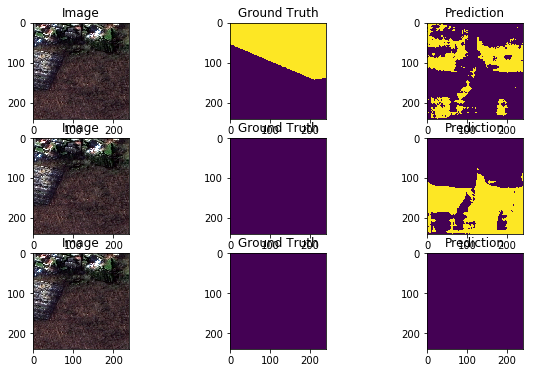

In [16]:
X, Y = example_generator.next()
plot_example(X, Y, model)

The model doesnt know the difference between dirt and forest.  Nice effort though.

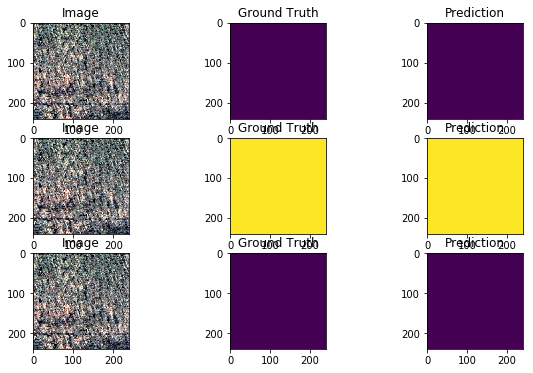

In [17]:
X, Y = example_generator.next()
plot_example(X, Y, model)

Bewm!

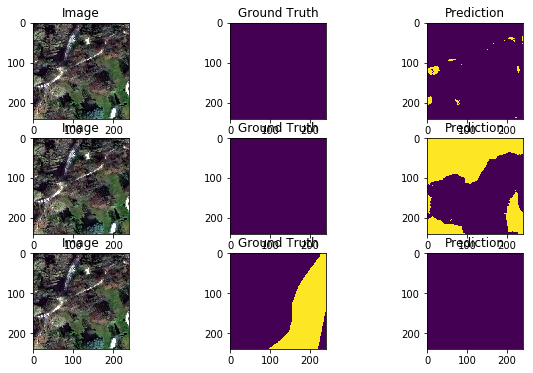

In [18]:
X, Y = example_generator.next()
plot_example(X, Y, model)

This example has bad ground truth.  The model found some trees that weren't even marked.  Hooray for the model!

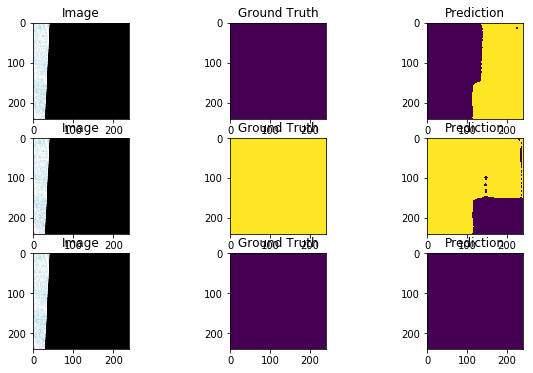

In [19]:
X, Y = example_generator.next()
plot_example(X, Y, model)

Garbage in, garbage out.

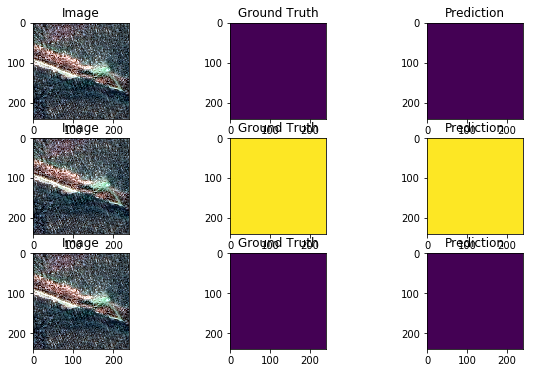

In [20]:
X, Y = example_generator.next()
plot_example(X, Y, model)

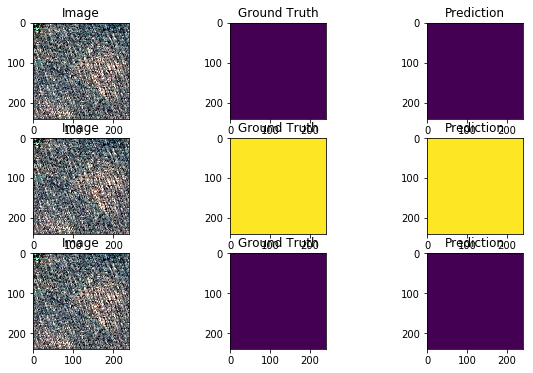

In [21]:
X, Y = example_generator.next()
plot_example(X, Y, model)

If you explore those results a bit, you'll see that the model is ok for detecting forest, but it struggles with residential and it's really terrible with water.  Paris does not have a lot of water, so the model didn't have much to learn from.  I expect that training on Shanghai would help a lot.

This model isn't very smart, and there are a few possibilities for why this happend.  Most likely, we need to train the model on more data, or the training set is just too imbalanced, since there really aren't a ton of positive examples in the training data.

Also, you'll see that some of the training data includes black areas.  This is because there was invalid imagery around the edges of some of the input images.  We could remove by excluding regions with lots of black pixels from the training set.  There are many ways to improve training like that, but I'm not going to get into it here because the point of these notebooks is to give you a simple example that's easy to follow.  You can try all kinds of improvements yourself.  I'll reccomend a few to start with:

1. Get more training data.  Train the model more, and vary the training set more.  The easiest way to do this is probably to write your own for loop around the call to `model.train`
2. Force the training set to be more balanced
3. Try transfer learning
5. Remove the missing (black) regions of images from the training set

I want to reiterate that Paris does not have a ton of data, so I would reccomend checking out Shanghai, Khartoum, or Vegas.